# Machine learning for genetic data — Part 4: Multitask learning

## Reload librairies and data

Let us first reload the librairies and data used in previous parts. You can run this entire section (until the "The 4W phenotype" section) "blindly".

In [1]:
# make sure graphics are displayed inline (rather than opened in new windows)
%matplotlib inline 

# imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pandas as pd

In [3]:
plt.rc('font', **{'size': 14}) # font size for text on plots

In [4]:
from sklearn import decomposition, linear_model, metrics, model_selection, preprocessing

In [5]:
import scipy.stats as st

In [6]:
import statsmodels.api as sm

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

### Load data

In [8]:
# Load the genotype data
genotype_df = pd.read_csv("data/athaliana_small.genotype.txt")
genotype_df = genotype_df.set_index("Sample")

In [9]:
# Load the 2W phenotype
phenotype_df = pd.read_csv('data/athaliana_small.2W.pheno', delim_whitespace=True)

In [10]:
# Create the corresponding response vector
y_2W = np.array(phenotype_df["2W"])

In [11]:
# Create the corresponding data matrix
X_2W = np.array(genotype_df.loc[phenotype_df["IID"]])

In [12]:
num_snps = X_2W.shape[1]

In [13]:
# Load the list of candidate genes
with open('data/candidate_genes.txt') as f:
    candidate_genes = f.readline().split()
    f.close()

In [14]:
# Load the SNP to gene mapping
genes_by_snp = {} # key: SNP, value = [genes in/near which this SNP is]
with open('data/snps_by_gene.txt') as f:
    for line in f:
        ls = line.split()
        gene_id = ls[0]
        for snp_id in ls[1:]:
            if not snp_id in genes_by_snp:
                genes_by_snp[snp_id] = []
            genes_by_snp[snp_id].append(gene_id) 

### Correct the phenotype for population structure

In [15]:
pca = decomposition.PCA(n_components=4)
pca.fit(X_2W)
principal_components = X_2W.dot(pca.components_.T) 

# Fit a linear model between the phenotype and the principal components
model = linear_model.LinearRegression()
model.fit(principal_components, y_2W)

# Compute the model's residuals
y_pred = model.predict(principal_components)
y_2W_corrected = y_2W - y_pred

### Functions to measure stability

In [16]:
def pearson_corr(vector1, vector2):
    """
    Returns Pearson's correlation between two vectors of 0 and 1. 
    """
    # if the first or the second vector is constant
    if (vector1 == vector1[0]).all() and (vector2 == vector2[0]).all():
            # return 1 if both are the same and 0 otherwise
            return 1. if (vector1[0] == vector2[0]) else 0.
    return st.pearsonr(vector1, vector2)[0]

Now we can define a function that measures the stability of a selection procedure.

In [17]:
def stability(X_train, y_train, selection_procedure, num_subsamples, subsample_size):
    """
    Sample the training data (X_train, y_train) num_subsamples times.
    Apply the selection procedure on each subsample.
    Return a mesure of stability of the procedure
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, ) np.array
       training labels
    selection_procedure: function
       input parameters: (training_data, training_labels)
       outputs: (n_features, ) np.array of 0 and 1 
           1 for selected features
           0 for non-selected features
    num_subsamples: int
        number of subsamples to use
    subsample_size: int
        number of samples in the subsample   
        
    Output
    ------
    pearson_corr: float
        Pearson's measure of stability of the selection procedure
    """
    n_samples, n_features = X_train.shape
    sample_indices = np.arange(n_samples) 
    
    # check there is the same number of samples in X and y
    assert len(y_train) == n_samples
    
    # check the subsample size is less than the sample size
    assert subsample_size < n_samples
    
    # run the feature selection procedure on the subsamples
    selected_features_list = []
    for idx in range(num_subsamples):
        # shuffle the indices
        np.random.shuffle(sample_indices)
        # create the subsample indices
        ss_indices = sample_indices[:subsample_size]
        # run the feature selection procedure
        # and append the results to selected_features_list
        selected_features_list.append(selection_procedure(X_train[ss_indices, :], y_train[ss_indices]))
    
    # compute the average pairwise Pearson's correlation between the list of selected features
    all_correlations = [pearson_corr(selected_features, selected_features_2) for (idx, selected_features) in enumerate(selected_features_list) \
                        for selected_features_2 in selected_features_list[idx+1:]]
    
    return np.nanmean(all_correlations)

## The 4W phenotype

The 4W phenotype is very similar to the 2W phenotype, except that the seeds have been vernelized for 4 weeks. We will repeat some of the analysis we did on the 2W phenotype on this phenotype.

### Load data

In [18]:
# Load the 4W phenotype
phenotype_4W_df = pd.read_csv('data/athaliana_small.4W.pheno', delim_whitespace=True)

In [19]:
# Create the corresponding response vector
y_4W = np.array(phenotype_4W_df["4W"])

In [20]:
# Create the corresponding data matrix
X_4W = np.array(genotype_df.loc[phenotype_4W_df["IID"]])

In [21]:
assert num_snps == X_4W.shape[1]

### T-tests

__Q: Complete the following code to obtain p-values for the uncorrected 4W phenotype__

In [22]:
pvalues_4W = []
for snp_idx in range(num_snps):
    # only look a the column corresponding to that SNP
    X_snp = # TODO
    
    # run a linear regression (with bias) between the phenotype and this SNP
    est = # TODO
    
    # get the p-value from the model 
    pvalues_4W.append(est.pvalues[1])

# convert the list of p-values to a numpy array
pvalues_4W = np.array(pvalues_4W)

### QQ plot

__Q: Obtain a QQ plot for -log10 of the p-values for the uncorrected 4W phenotype__

__Q: What is the genomic inflation factor here?__

### Correct for population stratification

__Q: Use the first 4 principal components to correct the y_4W phenotype for population stratification.__
Call the adjusted phenotype `y_4W_corrected`, the corresponding p-values `adjusted_pvalues_4W`, and compute the corresponding genomic inflation factor. You can also plot the corresponding QQ-plot.

### Manhattan plot

__Q: Plot the Manhattan plot for the `adjusted_pvalues_4W` p-values__.

## Comparing the two phenotypes

### Comparing the p-values

Let us start by computing the p-values for the 2W phenotype again:

In [34]:
pvalues_2W = []
for snp_idx in range(num_snps):
    # only look a the column corresponding to that SNP
    X_snp = X_2W[:, snp_idx]
    
    # run a linear regression (with bias) between the phenotype and this SNP
    X_snp = sm.add_constant(X_snp)
    est = sm.regression.linear_model.OLS(y_2W_corrected, X_snp)
    est = est.fit()
    
    # get the p-value from the model 
    pvalues_2W.append(est.pvalues[1])

# convert the list of p-values to a numpy array
pvalues_2W = np.array(pvalues_2W)

We can now plot each SNP with two coordinates: -log10 of its p-value for the 4W phenotype vs -log10 of its p-value for the 2W phenotype:

Text(0, 0.5, '-log10 of the p-value for 4W')

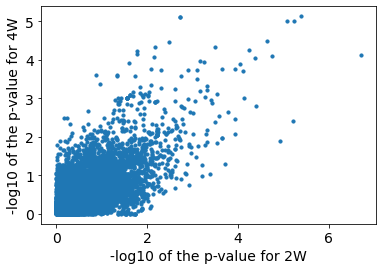

In [35]:
plt.scatter(-np.log10(pvalues_2W), -np.log10(adjusted_pvalues_4W), s=10)
plt.xlabel("-log10 of the p-value for 2W")
plt.ylabel("-log10 of the p-value for 4W")

### Comparing the Manhattan plots

Text(0.5, 1.0, 'Manhattan plot for 2W and 4W')

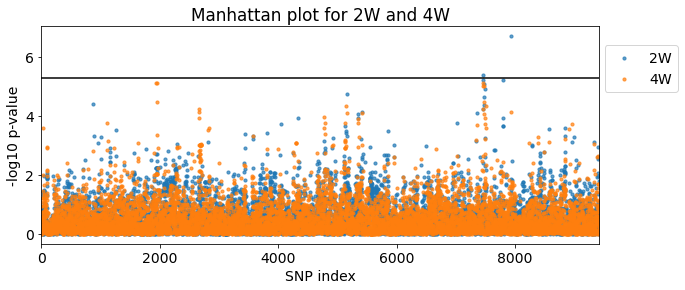

In [36]:
plt.figure(figsize = (10, 4))

plt.scatter(range(num_snps), -np.log10(pvalues_2W), s=10, 
            alpha=0.7, label="2W")
plt.scatter(range(num_snps), -np.log10(adjusted_pvalues_4W), s=10, 
            alpha=0.7, label="4W")

    
# significance threshold according to Bonferroni correction
significance_thr = 0.05 / num_snps
t = -np.log10(significance_thr)
plt.plot([0, num_snps], [t, t], color='black')

# plot labels
plt.xlabel("SNP index")
plt.ylabel("-log10 p-value")
plt.xlim([0, num_snps])
plt.legend(loc=(1.01, 0.7))
plt.title("Manhattan plot for 2W and 4W")

### Comparing the phenotypes

Let us start by identifying the samples for which both phenotypes are available:

In [37]:
iid_both_phenotypes = pd.Series(list(set(phenotype_df["IID"]).intersection(set(phenotype_4W_df["IID"]))))
print(f"{len(iid_both_phenotypes)} samples have both phenotypes.")

117 samples have both phenotypes.


In [38]:
# index the phenotypes DataFrames by "IID" to facilitate selection by IID
phenotype_2W_df = phenotype_df.set_index('IID')
phenotype_4W_df = phenotype_4W_df.set_index('IID')

# restrict phenotypes to samples available for both
y_2W_both = phenotype_2W_df.loc[iid_both_phenotypes]["2W"]
y_4W_both = phenotype_4W_df.loc[iid_both_phenotypes]["4W"]

Text(0, 0.5, '4W')

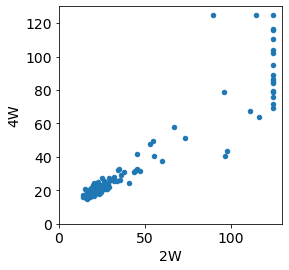

In [39]:
fig = plt.figure(figsize=(4, 4))

plt.scatter(y_2W_both, y_4W_both, s=20)

plt.xlim(0, 130)
plt.ylim(0, 130)
plt.xlabel("2W")
plt.ylabel("4W")

__Q: Based on the three previous plots, do you think it reasonable to make the assumption that the SNPs associated with both phenotypes are located in (almost) the same regions of the genome?__

**Answer:**

## Multitask Lasso

We will now use the multitask lasso to fit a lasso model to the 2W and the 4W phenotypes _simultaneously_. See [sklearn.linear_model.MultiTaskLasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskLasso.html#sklearn.linear_model.MultiTaskLasso) + [User Guide](http://scikit-learn.org/stable/auto_examples/linear_model/plot_multi_task_lasso_support.html)

### Restrict the design matrices to samples that have both phenotypes

We will consider a setting in which both phenotypes are available for all SNPs, because this is how the multitask lasso is implemented in scikit-learn.

In [40]:
X_both = np.array(genotype_df.loc[iid_both_phenotypes])

### Correct for population stratification

In [64]:
# Compute the first 4 principal components
pca = decomposition.PCA(n_components=4)
pca.fit(X_both)
principal_components = X_both.dot(pca.components_.T) 

In [65]:
# Correction
model = linear_model.LinearRegression()

# For 2W
model.fit(principal_components, y_2W_both)
y_pred = model.predict(principal_components)
y_2W_corrected = y_2W_both - y_pred

# For 4W
model.fit(principal_components, y_4W_both)
y_pred = model.predict(principal_components)
y_4W_corrected = y_4W_both - y_pred

### Create a multilabel response array

In [66]:
y_both = np.vstack((y_2W_corrected, y_4W_corrected)).T

In [67]:
y_both.shape

(117, 2)

__Q: How does this numpy array differ from the one we used for the single-task lasso?__

__Anwer:__

### Split the data in train/test

In [68]:
X_both_tr, X_both_te, y_both_tr, y_both_te = \
    model_selection.train_test_split(X_both, y_both, test_size=0.2, random_state=42)
print(f"Training set shape: {X_both_tr.shape}\nTest set shape: {X_both_te.shape}")

Training set shape: (93, 9419)
Test set shape: (24, 9419)


### Scale the phenotypes

In [69]:
scaler = preprocessing.StandardScaler()
scaler.fit(y_both_tr)
y_both_tr_scaled = scaler.transform(y_both_tr)

In [70]:
y_both_te_scaled = scaler.transform(y_both_te)

### Fitting a multitask Lasso

In [71]:
alpha_max, alpha_min = linear_model._coordinate_descent._alpha_grid(X_both_tr, y_both_tr_scaled[:, 0], n_alphas=2, l1_ratio=0.5)
print(f"The maximum value of alpha for a Lasso on 2W is {alpha_max:.3f}.")

The maximum value of alpha for a Lasso on 2W is 0.443.


In [72]:
alpha_max, alpha_min = linear_model._coordinate_descent._alpha_grid(X_both_tr, y_both_tr_scaled[:, 1], n_alphas=2, l1_ratio=0.5)
print(f"The maximum value of alpha for a Lasso on 4W is {alpha_max:.3f}.")

The maximum value of alpha for a Lasso on 4W is 0.434.


In [73]:
mtlasso = linear_model.MultiTaskLasso(fit_intercept=True, max_iter=1000)

In [91]:
# Grid of values for the two regularization parameters
alphas = linear_model._coordinate_descent._alpha_grid(X_both_tr, y_both_tr_scaled[:, 0], n_alphas=10, eps=1e-2)

# Set up the grid search cross validation
model_mt = model_selection.GridSearchCV(mtlasso, param_grid={'alpha': alphas}, 
                                        cv=5, verbose=3)

# Use the grid search cross validation on the training data
model_mt.fit(X_both_tr, y_both_tr_scaled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..........alpha=0.2214933328835333;, score=0.001 total time=   0.0s
[CV 2/5] END .........alpha=0.2214933328835333;, score=-0.011 total time=   0.0s
[CV 3/5] END .........alpha=0.2214933328835333;, score=-0.203 total time=   0.1s
[CV 4/5] END ..........alpha=0.2214933328835333;, score=0.053 total time=   0.0s
[CV 5/5] END .........alpha=0.2214933328835333;, score=-0.131 total time=   0.0s
[CV 1/5] END .........alpha=0.1327817646143285;, score=-0.042 total time=   0.1s
[CV 2/5] END ..........alpha=0.1327817646143285;, score=0.175 total time=   0.1s
[CV 3/5] END .........alpha=0.1327817646143285;, score=-0.209 total time=   0.1s
[CV 4/5] END ..........alpha=0.1327817646143285;, score=0.101 total time=   0.1s
[CV 5/5] END ..........alpha=0.1327817646143285;, score=0.126 total time=   0.2s
[CV 1/5] END ........alpha=0.07960057661584678;, score=-0.120 total time=   0.2s
[CV 2/5] END .........alpha=0.07960057661584678;

GridSearchCV(cv=5, estimator=MultiTaskLasso(),
             param_grid={'alpha': array([0.22149333, 0.13278176, 0.07960058, 0.04771929, 0.02860696,
       0.01714942, 0.01028081, 0.00616318, 0.00369473, 0.00221493])},
             verbose=3)

In [92]:
print(f"The best value of alpha is {model_mt.best_params_['alpha']:.4f}")

The best value of alpha is 0.0796


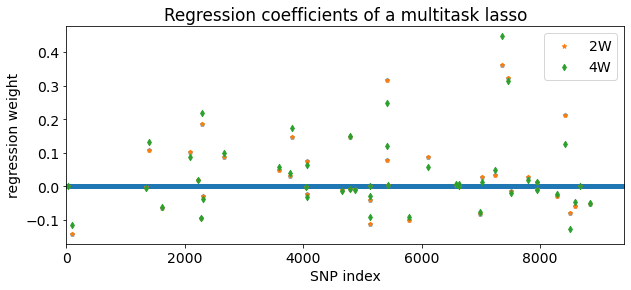

In [93]:
plt.figure(figsize = (10, 4))
# plot for 2W
plt.scatter(range(num_snps), model_mt.best_estimator_.coef_[0, :], s=10) 
nonzero_weight_indices_2W = np.where(model_mt.best_estimator_.coef_[0, :])[0]
plt.scatter(nonzero_weight_indices_2W, model_mt.best_estimator_.coef_[0, nonzero_weight_indices_2W], 
            marker="*", s=20, label="2W") 
# plot for 4W
nonzero_weight_indices_4W = np.where(model_mt.best_estimator_.coef_[1, :])[0]
plt.scatter(nonzero_weight_indices_4W, model_mt.best_estimator_.coef_[1, nonzero_weight_indices_4W], 
            marker="d", s=20, label="4W") 

plt.xlabel("SNP index")
plt.ylabel("regression weight")
plt.xlim([0, num_snps])
plt.title("Regression coefficients of a multitask lasso")
plt.legend()

__Q: Compare these regression coefficients to that of a lasso. Can you see why we can hope this solution to be more stable?__

__Answer:__

In [94]:
print(f"{len(set(nonzero_weight_indices_2W).intersection(set(nonzero_weight_indices_4W)))} SNPs were selected for both phenotypes")

47 SNPs were selected for both phenotypes


In [95]:
selected_candidate_genes_2W = []
num_snps_pointing_to_candidates = 0
for snp_name in genotype_df.columns[nonzero_weight_indices_2W]:
    matching_genes = genes_by_snp[snp_name]
    candidate_matching_genes = set(matching_genes).intersection(set(candidate_genes))
    if len(candidate_matching_genes):
        num_snps_pointing_to_candidates += 1
        selected_candidate_genes_2W.extend(candidate_matching_genes)
print(f"{num_snps_pointing_to_candidates} of the {len(nonzero_weight_indices_2W)} selected SNP(s) for 2W point to {len(selected_candidate_genes_2W)} candidate genes.")

47 of the 47 selected SNP(s) for 2W point to 50 candidate genes.


In [96]:
selected_candidate_genes_4W = []
num_snps_pointing_to_candidates = 0
for snp_name in genotype_df.columns[nonzero_weight_indices_4W]:
    matching_genes = genes_by_snp[snp_name]
    candidate_matching_genes = set(matching_genes).intersection(set(candidate_genes))
    if len(candidate_matching_genes):
        num_snps_pointing_to_candidates += 1
        selected_candidate_genes_4W.extend(candidate_matching_genes)
print(f"{num_snps_pointing_to_candidates} of the {len(nonzero_weight_indices_4W)} selected SNP(s) for 4W point to {len(selected_candidate_genes_4W)} candidate genes.")

47 of the 47 selected SNP(s) for 4W point to 50 candidate genes.


### Quality of model fit

As before, we can check how well our model fits the data it was trained on.

__Q: Compute the percentage of variance explained by the multitask lasso on the training set. Plot the predictions vs the true phentoypes.__

__Q: How well does the model fit the training data? Compare to the single-task lasso.__

**Answer:**

### Model predictive power 

__Q: Compute the percentage of variance explained by the multitask lasso on the test set. Plot the predictions vs the true phentoypes.__

__Q: How well does the model predict on the test data? Compare to previous models__

**Answer:**

## Stability of Multitask Lasso

Let us wrap what we did in the Multitask Lasso section into a method which takes a data set as input and selects the features significantly associated with the output.

In [103]:
def mtlasso_selection_procedure(X_train, y_train):
    """
    Fits a multitask lasso to the data. Returns the features with non-zero coefficients.
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, n_tasks) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected for task 0
            selection[j] = 1 otherwise.       
    """
    # create a multitask lasso object
    mtlasso = linear_model.MultiTaskLasso(fit_intercept=True, max_iter=1000)
    
    # Grid of values for the regularization hyperparameters
    alphas = linear_model._coordinate_descent._alpha_grid(X_train, y_train[:, 0], n_alphas=10, eps=1e-2)


    # Set up the grid search cross validation
    model_mtl1 = model_selection.GridSearchCV(mtlasso, param_grid={'alpha': alphas}, 
                                              cv=5)

    # Use the grid search cross validation on the training data
    model_mtl1.fit(X_train, y_train)
    
    # Consider the non-zero coefficients as selected
    return(np.where(model_mtl1.best_estimator_.coef_[0, :], 1, 0))

In [104]:
# use 90% of the data size as subsample size
subsize = int(round(0.9*len(y_both_tr)))

# compute stability
mtlasso_stab = stability(X_both_tr, y_both_tr_scaled, mtlasso_selection_procedure, 10, subsize)

In [105]:
print(f"The stability of the Multitask Lasso selection for phenotype 2W is: {mtlasso_stab:.3f}")

The stability of the Multitask Lasso selection for phenotype 2W is: 0.482


__Q: Compare this stability to those previously obtained with the t-test and various lasso variants__

__Anwer:__

__Q: How could you modify the above code to obtain the stability of the Multitask Lasso selection procedure for the 4W phenotype?__

__Anwer:__

## Stability of Multitask Lasso with fixed regularization coefficient

We can also fix the values of the regularization coefficient to see whether this improves stability.

__Q: Write a function `fixed_hyperparam_mtlasso_selection_procedure` that has the following signature:__

In [113]:
def fixed_hyperparam_mtlasso_selection_procedure(X_train, y_train):
    """
    Fits a multitask lasso on the data. Returns the features with non-zero coefficients.

    Rather than cross-validating the value of alpha, cheat
    and use the previously determined optimal value.
    
    Input parameters
    ----------------
    X_train: (n_samples, n_features) np.array
       training data
    y_train: (n_samples, n_tasks) np.array
       training labels
    
    Output
    ------
    selection: (n_features, ) np.array
        for j=1..n_features:
            selection[j] = 0 if j is not selected for task 0
            selection[j] = 1 otherwise.       
    """

__Q: Now use this function to compute the stability of the multitask lasso selection with fixed regularization hyperparameter, and compare it to the previously obtained stabilities.__

## Further practice: use a multitask Elastic Net
See the [user guide](https://scikit-learn.org/stable/modules/linear_model.html#multi-task-elastic-net) and [API](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.MultiTaskElasticNet.html#sklearn.linear_model.MultiTaskElasticNet) for the Multitask Elastic Net.

__Q: Run the same study as with the Multitask Lasso, but with the Multitask Elastic Net instead__